# Spectrum Alignment

OpenMS provides several ways to find matching peaks between two mass
spectra. The most basic one
[SpectrumAlignment](https://pyopenms.readthedocs.io/en/latest/apidocs/_autosummary/pyopenms/pyopenms.SpectrumAlignment.html)
returns a list of matching peak indices between a query and target mass
spectrum. In this example, we take an observed (measured) mass spectrum
and align a theoretical mass spectrum to it.

First we load a (chemically modified) peptide:

In [ ]:
from urllib.request import urlretrieve
import pyopenms as oms

gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master"
urlretrieve(
    gh + "/src/data/YIC(Carbamidomethyl)DNQDTISSK.mzML", "observed.mzML"
)

exp = oms.MSExperiment()
# Load mzML file and obtain spectrum for peptide YIC(Carbamidomethyl)DNQDTISSK
oms.MzMLFile().load("observed.mzML", exp)

# Get first spectrum
spectra = exp.getSpectra()
observed_spectrum = spectra[0]

Now we generate the theoretical mass spectrum of that peptide:

In [ ]:
tsg = oms.TheoreticalSpectrumGenerator()
theo_spectrum = oms.MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")
p.setValue("add_metainfo", "true")
tsg.setParameters(p)
peptide = oms.AASequence.fromString("YIC(Carbamidomethyl)DNQDTISSK")
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)

Now we can plot the observed and theoretical mass spectrum as a mirror
plot:

In [ ]:
import matplotlib.pyplot as plt
from pyopenms.plotting import mirror_plot_spectrum

mirror_plot_spectrum(
    observed_spectrum,
    theo_spectrum,
    spectrum_bottom_kws={"annotate_ions": False},
)
plt.show()

which produces

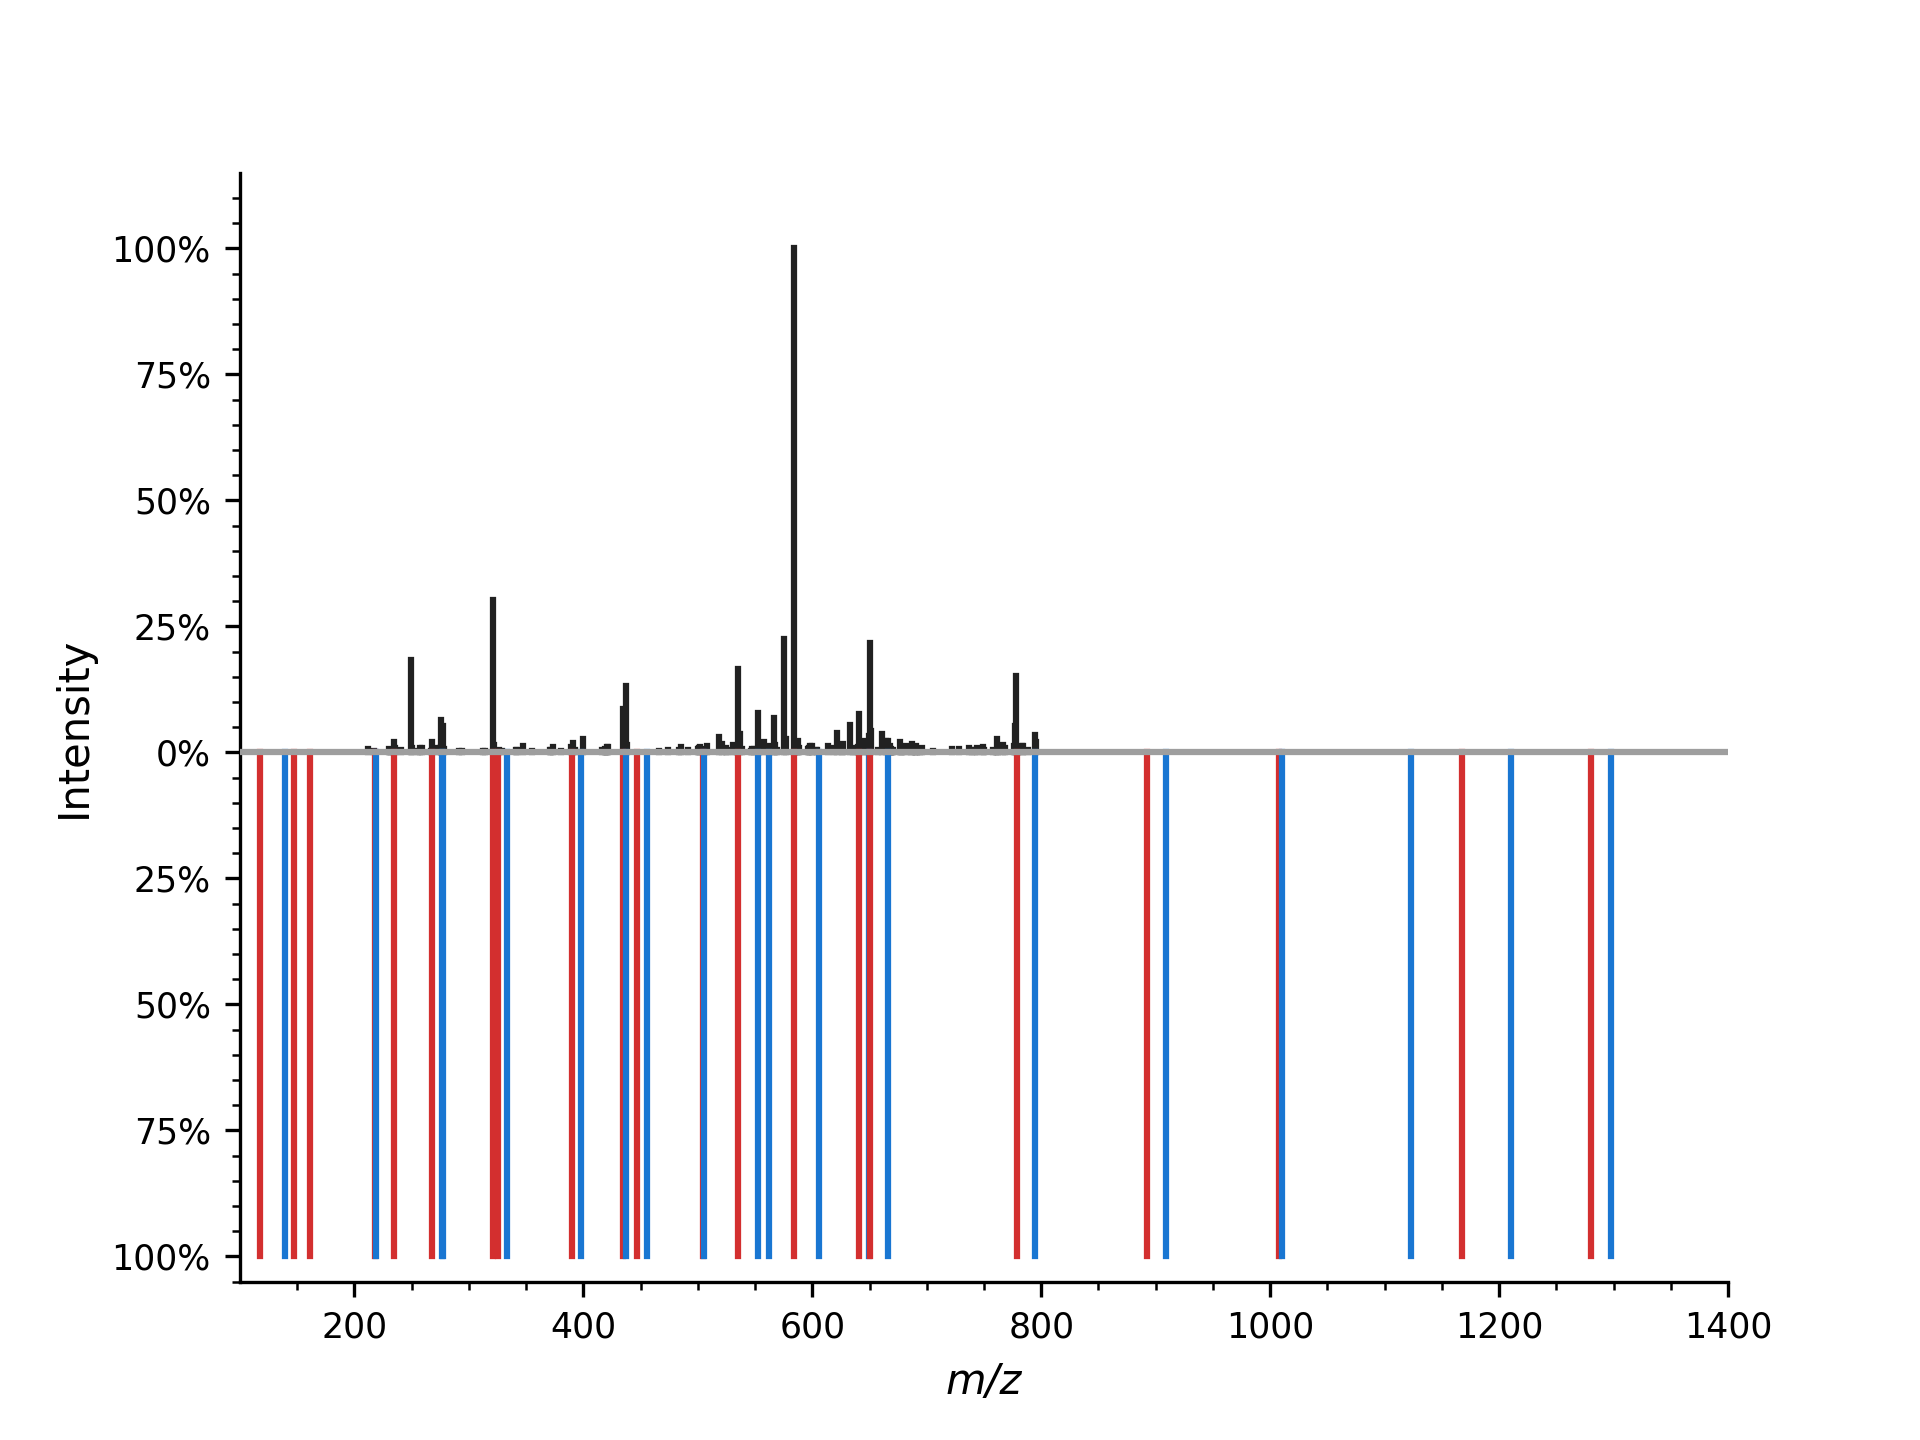

Now we want to find matching peaks (in m/z) between the observed and the
theoretical spectrum (note: we ignore the peak intensity during the
alignment).

In [ ]:
alignment = []
spa = oms.SpectrumAlignment()
p = spa.getParameters()
# use 0.5 Da tolerance for m/z (Note: for high-resolution data we could also use ppm by setting the is_relative_tolerance value to true)
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)
# align both spectra
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

The alignment contains a list of matched peak indices. We can simply
inspect matching peaks with:

In [ ]:
from tabulate import tabulate


# Print matching ions and mz from theoretical spectrum
print("Number of matched peaks: " + str(len(alignment)))
t = []
for theo_idx, obs_idx in alignment:
    ion_name = theo_spectrum.getStringDataArrays()[0][theo_idx].decode()
    ion_charge = theo_spectrum.getIntegerDataArrays()[0][theo_idx]
    t.append(
        [
            ion_name,
            str(ion_charge),
            str(theo_spectrum[theo_idx].getMZ()),
            str(observed_spectrum[obs_idx].getMZ()),
        ]
    )
print(tabulate(t, headers=["ion", "charge", "theo. m/z", "observed m/z"]))

``` output
Number of matched peaks: 16
ion      charge    theo. m/z    observed m/z
-----  --------  -----------  --------------
y2+           1      234.145         234.123
y5++          2      268.158         268.105
b2+           1      277.155         277.246
y3+           1      321.177         321.297
y4+           1      434.261         434.288
b3+           1      437.185         437.291
y5+           1      535.309         535.189
b4+           1      552.212         552.338
b9++          2      562.24          562.421
y10++         2      584.251         584.412
y11++         2      640.793         640.954
```

The mirror plot can also be used to visualize the aligned mass spectrum:

In [ ]:
match_peaks_observed, match_peaks_theoretical = list(zip(*alignment))
mirror_plot_spectrum(
    observed_spectrum,
    theo_spectrum,
    spectrum_top_kws={"matched_peaks": match_peaks_theoretical},
    spectrum_bottom_kws={"annotate_ions": False, "matched_peaks": match_peaks_observed}
)
plt.show()

which produces

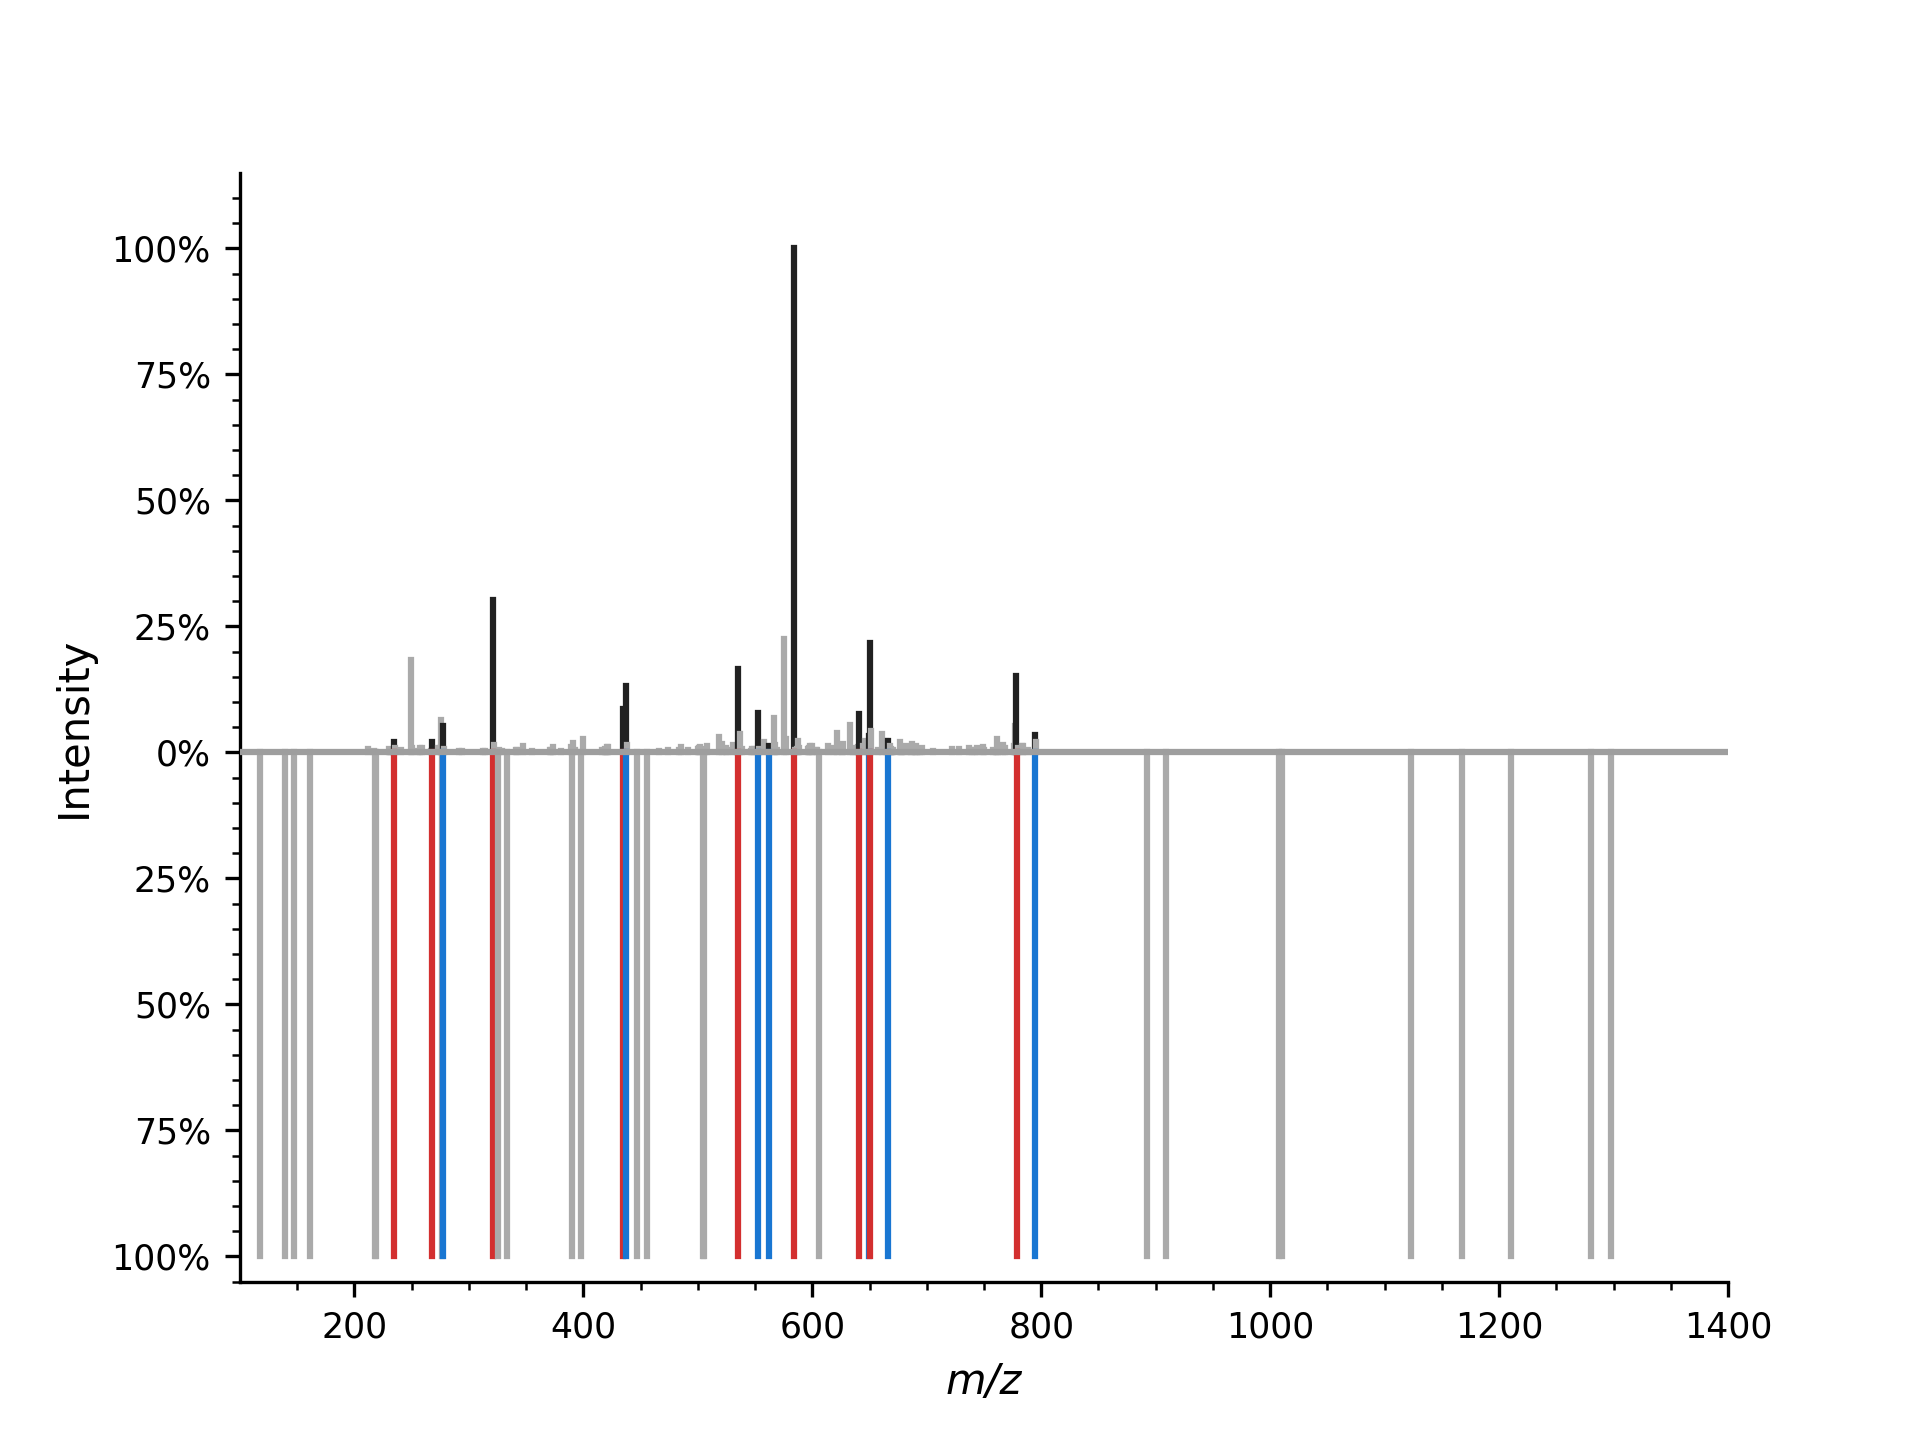